In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_csv(r'C:\Users\SHAWN\Downloads\Fraud.csv')

In [3]:
print(df.head())
print(df.dtypes)
print(df.describe())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
step                int64
type               object
amount            float64
nameOrig           object
o

In [4]:
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [5]:
numeric_columns = df.select_dtypes(include=['number']).columns
string_columns = df.select_dtypes(include=['object', 'string']).columns

In [6]:
for col in numeric_columns:
    col_mean = df[col].mean()
    df[col] = df[col].fillna(col_mean) 

In [7]:
def fill_string_columns(df, string_columns):
    modes = {col: df[col].mode()[0] for col in string_columns}
    for col in string_columns:
        df[col] = df[col].fillna(modes[col])
    return df

In [8]:
for col in numeric_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[col] >= (Q1 - 1.5 * IQR)) & (df[col] <= (Q3 + 1.5 * IQR))]

                    step    amount  oldbalanceOrg  newbalanceOrig  \
step            1.000000 -0.016770      -0.001374       -0.000496   
amount         -0.016770  1.000000       0.221509       -0.242910   
oldbalanceOrg  -0.001374  0.221509       1.000000        0.404820   
newbalanceOrig -0.000496 -0.242910       0.404820        1.000000   
oldbalanceDest -0.011004  0.392163      -0.026756       -0.143009   
newbalanceDest -0.019177  0.652329       0.053673       -0.200109   
isFraud              NaN       NaN            NaN             NaN   
isFlaggedFraud       NaN       NaN            NaN             NaN   

                oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
step                 -0.011004       -0.019177      NaN             NaN  
amount                0.392163        0.652329      NaN             NaN  
oldbalanceOrg        -0.026756        0.053673      NaN             NaN  
newbalanceOrig       -0.143009       -0.200109      NaN             NaN  
oldbalan

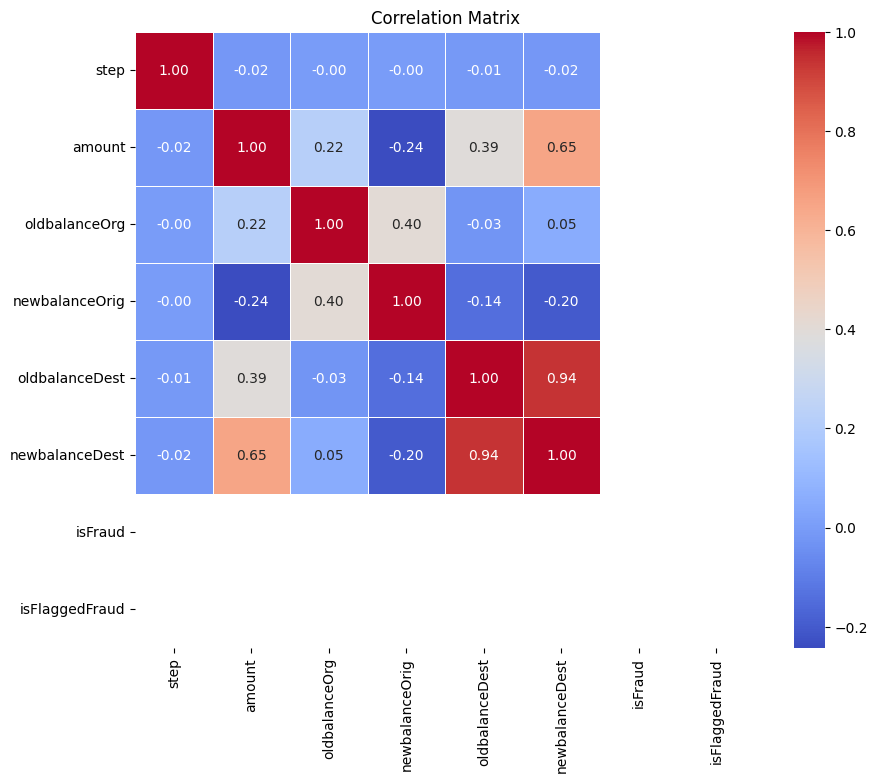

In [9]:
numeric_df = df.select_dtypes(include=['number'])
corr = numeric_df.corr()
print(corr)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

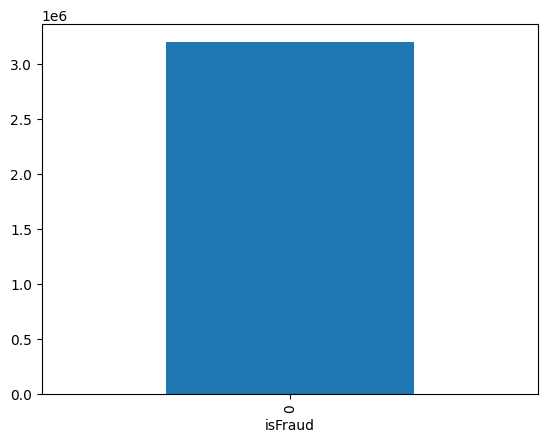

In [10]:
value_counts = df['isFraud'].value_counts()
value_counts.plot(kind='bar')
plt.show()

In [11]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

In [12]:
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns

In [13]:
def reduce_cardinality(df, categorical_columns, threshold=100):
    for col in categorical_columns:
        counts = df[col].value_counts()
        to_replace = counts[counts < threshold].index
        df[col] = df[col].where(df[col].isin(to_replace), 'Other')
    return df

In [14]:
def label_encode(df, categorical_columns):
    encoder = LabelEncoder()
    for col in categorical_columns:
        df[col] = encoder.fit_transform(df[col])
    return df

In [15]:
def simple_process_data(df, categorical_columns):
    df = reduce_cardinality(df, categorical_columns)
    return df

In [16]:
X_train_processed = simple_process_data(X_train, categorical_columns)
X_test_processed = simple_process_data(X_test, categorical_columns)

In [17]:
X_train_encoded = label_encode(X_train_processed, categorical_columns)
X_test_encoded = label_encode(X_test_processed, categorical_columns)

In [19]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [22]:
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

In [24]:
X_train_numeric = X_train.select_dtypes(include=['float64', 'int64'])
X_test_numeric = X_test.select_dtypes(include=['float64', 'int64'])
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

In [25]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_numeric.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_numeric.columns)

In [26]:
X_train_final = pd.concat([X_train_scaled, X_train_processed], axis=1)
X_test_final = pd.concat([X_test_scaled, X_test_processed], axis=1)

In [30]:
if X_train_final.isnull().sum().sum() > 0:
    imputer = SimpleImputer(strategy='mean')
    X_train_final_imputed = imputer.fit_transform(X_train_final)
    X_train_final = pd.DataFrame(X_train_final_imputed, columns=X_train_final.columns)

In [31]:
if X_test_final.isnull().sum().sum() > 0:
    X_test_imputed = imputer.transform(X_test_final)
    X_test_final = pd.DataFrame(X_test_imputed, columns=X_test_final.columns)

In [32]:
assert X_train_final.isnull().sum().sum() == 0
assert X_test_final.isnull().sum().sum() == 0

In [38]:
print(f"Classes in target variable: {y_train.nunique()}")

Classes in target variable: 1


In [41]:
if y_train.nunique() > 1:
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train_final, y_train)
    print("SMOTE applied successfully")
else:
    X_resampled, y_resampled = X_train_final, y_train
    print("The target variable has only one class, SMOTE cannot be applied.")

The target variable has only one class, SMOTE cannot be applied.


In [42]:
model = RandomForestClassifier(random_state=42)
model.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [45]:
print(f"Shape of X_test_final: {X_test_final.shape}")
print(f"Shape of y_test: {y_test.shape}")
X_test_final, y_test = X_test_final.align(y_test, join='inner', axis=0)
y_pred = model.predict(X_test_final)
print(classification_report(y_test, y_pred))
print(f"Unique values in y_test: {y_test.unique()}")
if len(y_test.unique()) == 2:
    y_pred_proba = model.predict_proba(X_test_final)[:, 1]
    print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
else:
    print("Cannot compute ROC-AUC: y_test contains less than two classes.")

Shape of X_test_final: (263512, 20)
Shape of y_test: (263512,)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    263512

    accuracy                           1.00    263512
   macro avg       1.00      1.00      1.00    263512
weighted avg       1.00      1.00      1.00    263512

Unique values in y_test: [0]
Cannot compute ROC-AUC: y_test contains less than two classes.
